In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
import pyamg

In [2]:
def central_stencil(k, h):
    """
    Creates the second-order diffrence stencil
    """
    stencil = np.zeros((3, 3))
    stencil[1, 1] = 4 - k**2*h**2
    stencil[0, 1] = -1
    stencil[1, 0] = -1
    stencil[1, 2] = -1
    stencil[2, 1] = -1
    return stencil

In [3]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

## 生成离散系统

In [16]:
k = 6
n = 2**k - 1
h = 1/(n+1)
kwave = 25

print(n)

centralA = central_stencil(kwave, h)
print(centralA)

A = stencil_grid(centralA, (n, n))

f = np.ones((n,n))*h**2   #* h^2乘到这里
f = f.ravel()

# np.save("A.npy", A.todense())
# np.save("f.npy", f)

63
[[ 0.         -1.          0.        ]
 [-1.          3.84741211 -1.        ]
 [ 0.         -1.          0.        ]]


## AMG

In [13]:
ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
print(ml)                                           # print hierarchy information
x = ml.solve(f, tol=1e-10)                          # solve Ax=b to a tolerance of 1e-10
print("residual: ", np.linalg.norm(f-A*x))          # compute norm of residual vector

multilevel_solver
Number of Levels:     8
Operator Complexity:  2.196
Grid Complexity:      1.668
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0        65025       324105 [45.55%]
    1        32513       290577 [40.83%]
    2         8190        72692 [10.22%]
    3         2077        18305 [ 2.57%]
    4          512         4468 [ 0.63%]
    5          133         1133 [ 0.16%]
    6           32          270 [ 0.04%]
    7            8           50 [ 0.01%]

residual:  nan


## Krylov subspace method

### CG

In [17]:
lim = 300
res1 = np.linalg.norm(f)**2


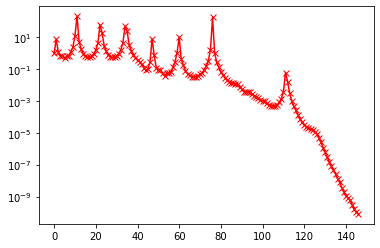

In [18]:

res_cg = [1]
def cg_rst(x):
    res_cg.append(np.linalg.norm(f-A@x)**2/res1)
sol = sp.sparse.linalg.cg(A, f, callback=cg_rst)
plt.semilogy(res_cg[:lim], marker='x',color='r', label='CG')

### GMRES

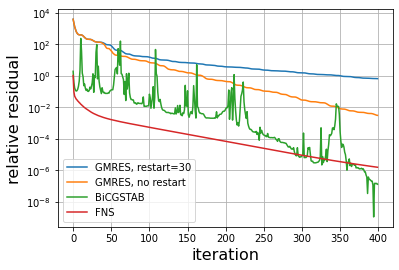

In [21]:
lim=400
res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r)**2/res1)
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r)**2/res1)

sol = sp.sparse.linalg.gmres(A, f, restart=30, callback=gmres_rst_cl)
sol = sp.sparse.linalg.gmres(A, f, restart=n, callback=gmres_rst)

plt.semilogy(res_gmres_rst[:lim], label='GMRES, restart=30')
plt.semilogy(res_gmres[:lim],label='GMRES, no restart')
plt.semilogy(res_all_bicgstab[:lim], label='BiCGSTAB')

FNS = np.load("/home/kaijiang/cuichen/FNSsummer/0909/data/FNS25.npy")
plt.semilogy(FNS[:lim],label='FNS')

plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative residual', fontsize=16)
plt.grid()
plt.legend()
plt.savefig('/home/kaijiang/cuichen/FNSsummer/0909/data/Helmholtz25.jpg', dpi=300)

### BiCG

In [7]:
res_all_bicg = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(f-A@x)**2/res1)
    
sol = sp.sparse.linalg.bicg(A, f, x0=np.random.randn(A.shape[0]), callback=bicg_cl)
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')


NameError: name 'res1' is not defined

### BiCGSTAB

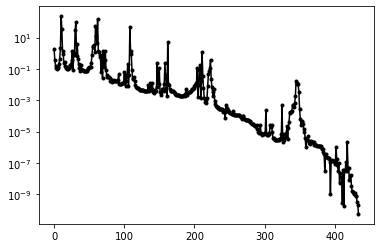

In [19]:
res_all_bicgstab = []
def bicgstab_cl(x):
    res_all_bicgstab.append(np.linalg.norm(f-A@x)**2/res1)
    
sol = sp.sparse.linalg.bicgstab(A, f, x0=np.zeros(A.shape[0]), callback=bicgstab_cl)
lim = 500
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')